In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
from keras import layers, models
from keras.callbacks import Callback
from keras.datasets import reuters
from keras.utils import np_utils

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
print(f'train_data: {train_data.shape}')
print(f'train_labels: {train_labels.shape}')
print(f'test_data: {test_data.shape}')
print(f'test_labels: {test_labels.shape}')

train_data: (8982,)
train_labels: (8982,)
test_data: (2246,)
test_labels: (2246,)


In [3]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Currently Keras does not include the reuters datasets labels.
# See: https://github.com/keras-team/keras/issues/12072
label_index = [
    'cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
    'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
    'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
    'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
    'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead'
]

def decode_x(data):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in data])

def decode_y(index):
    return label_index[index]

In [4]:
decoded_text = decode_x(train_data[0])
decoded_label = decode_y(train_labels[0])
print('text: ', decoded_text)
print('label: ', decoded_label)

text:  ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
label:  earn


In [5]:
def vectorize_sequences(sequences, dimension=10000):
    """
    One-hot encode lists to turn them into vectors of 0s and 1s.
    Done manually for maximum clarity.
    """
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

def to_categorical(labels, dimension=46):
    """
    One-hot encoding of the labels consists of embedding each label as 
    an all-zero vector with a 1 in the place of the label index.
    See: from keras.utils.np_utils import to_categorical
    """
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [6]:
x_train = vectorize_sequences(train_data)
y_train = to_categorical(train_labels)
# y_train = train_labels # Use loss='sparse_categorical_crossentropy'

x_val = x_train[:1000]
y_val = y_train[:1000]

partial_x_train = x_train[1000:]
partial_y_train = y_train[1000:]

x_test = vectorize_sequences(test_data)
y_test = np_utils.to_categorical(test_labels) # Using karas.utils here for variety.
# y_test = test_labels # Use loss='sparse_categorical_crossentropy'

In [7]:
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'partial_x_train: {partial_x_train.shape}')
print(f'partial_y_train: {partial_y_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

x_train: (8982, 10000)
y_train: (8982, 46)
x_val: (1000, 10000)
y_val: (1000, 46)
partial_x_train: (7982, 10000)
partial_y_train: (7982, 46)
x_test: (2246, 10000)
y_test: (2246, 46)


In [8]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(46, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
dense_1 (Dense)              (None, 46)                5934      
Total params: 1,286,062
Trainable params: 1,286,062
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
model.compile(
    loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop'
)

In [10]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=9,
    batch_size=512,
    validation_data=(x_val, y_val)
)

Epoch 1/9
16/16 [==============================] - 1s 32ms/step - loss: 2.2324 - accuracy: 0.6074 - val_loss: 1.4571 - val_accuracy: 0.7210
Epoch 2/9
16/16 [==============================] - 0s 22ms/step - loss: 1.1265 - accuracy: 0.7749 - val_loss: 1.1216 - val_accuracy: 0.7740
Epoch 3/9
16/16 [==============================] - 0s 22ms/step - loss: 0.7792 - accuracy: 0.8419 - val_loss: 0.9583 - val_accuracy: 0.8060
Epoch 4/9
16/16 [==============================] - 0s 22ms/step - loss: 0.5728 - accuracy: 0.8875 - val_loss: 0.8825 - val_accuracy: 0.8180
Epoch 5/9
16/16 [==============================] - 0s 22ms/step - loss: 0.4361 - accuracy: 0.9144 - val_loss: 0.8333 - val_accuracy: 0.8240
Epoch 6/9
16/16 [==============================] - 0s 22ms/step - loss: 0.3437 - accuracy: 0.9300 - val_loss: 0.8273 - val_accuracy: 0.8280
Epoch 7/9
16/16 [==============================] - 0s 22ms/step - loss: 0.2741 - accuracy: 0.9416 - val_loss: 0.8261 - val_accuracy: 0.8270
Epoch 8/9
16/16 [===

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

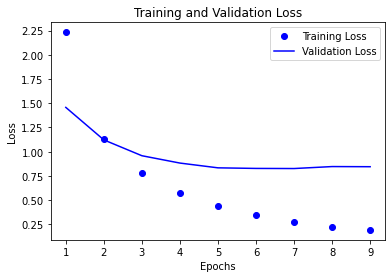

In [12]:
train_loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

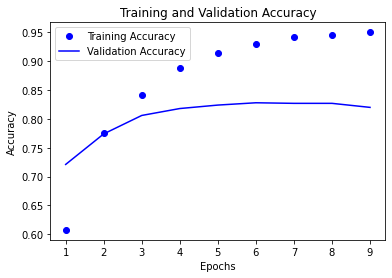

In [13]:
train_acc = history_dict.get('accuracy')
val_acc = history_dict.get('val_accuracy')
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 1ms/step - loss: 0.9265 - accuracy: 0.7996


[0.9265316128730774, 0.7996438145637512]

In [15]:
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy) # If network just randomly picks outputs.
hits_array = test_labels == test_labels_copy
np.sum(hits_array) / len(test_labels) # Count of correct classifications / total count.

0.18967052537845058

In [16]:
predictions = model.predict(x_test)

In [17]:
prediction_labels = np.argmax(predictions, axis=-1)
(incorrect_predictions,) = np.nonzero(prediction_labels != test_labels) # https://stackoverflow.com/a/39303937
incorrect_percent = len(incorrect_predictions) / len(test_data)
print('incorrect percent: ', incorrect_percent)
print('first 10 incorrect label indices: ', incorrect_predictions[:10])
incorrect_example_index = 16
print('text: ', decode_x(test_data[incorrect_example_index]))
print('predicted label: ', decode_y(prediction_labels[incorrect_example_index]))
print('correct label: ', decode_y(test_labels[incorrect_example_index]))

incorrect percent:  0.20035618878005343
first 10 incorrect label indices:  [ 4 10 16 32 33 36 40 52 70 71]
text:  ? ? ltd said it has closed on a 500 000 dlr long term mortgage loan in connection with its previous purchase of a ? fla plant replacing a short term borrowing the company said full production at the plant will start immediately reuter 3
predicted label:  acq
correct label:  alum


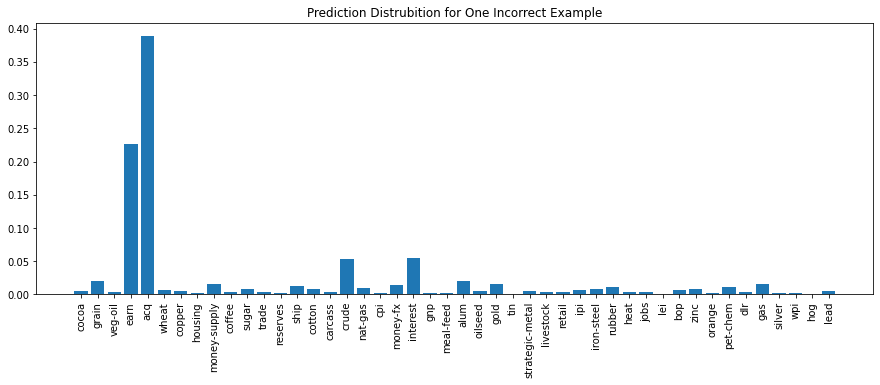

In [18]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.bar(label_index, predictions[incorrect_example_index])
plt.title('Prediction Distrubition for One Incorrect Example')
plt.show()